In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

from zipfile import ZipFile
import os
for i in os.listdir('C:/Users/mehmu/Desktop/PyProjects/Projects/Unlocked/KaggleComp/KaggleHouse'):
    if '.zip' in i:
        print(i)
        with ZipFile(i, 'r') as zipObj:
            zipObj.extractall()
        os.remove(i)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
shap_t,shap_p = stats.shapiro(df['SalePrice'])

print("Skewness: %f" % abs(df['SalePrice']).skew())
print("Kurtosis: %f" % abs(df['SalePrice']).kurt())
print("Shapiro_Test: %f" % shap_t)
print("Shapiro_Test: %f" % shap_p)

Skewness: 1.882876
Kurtosis: 6.536282
Shapiro_Test: 0.869672
Shapiro_Test: 0.000000


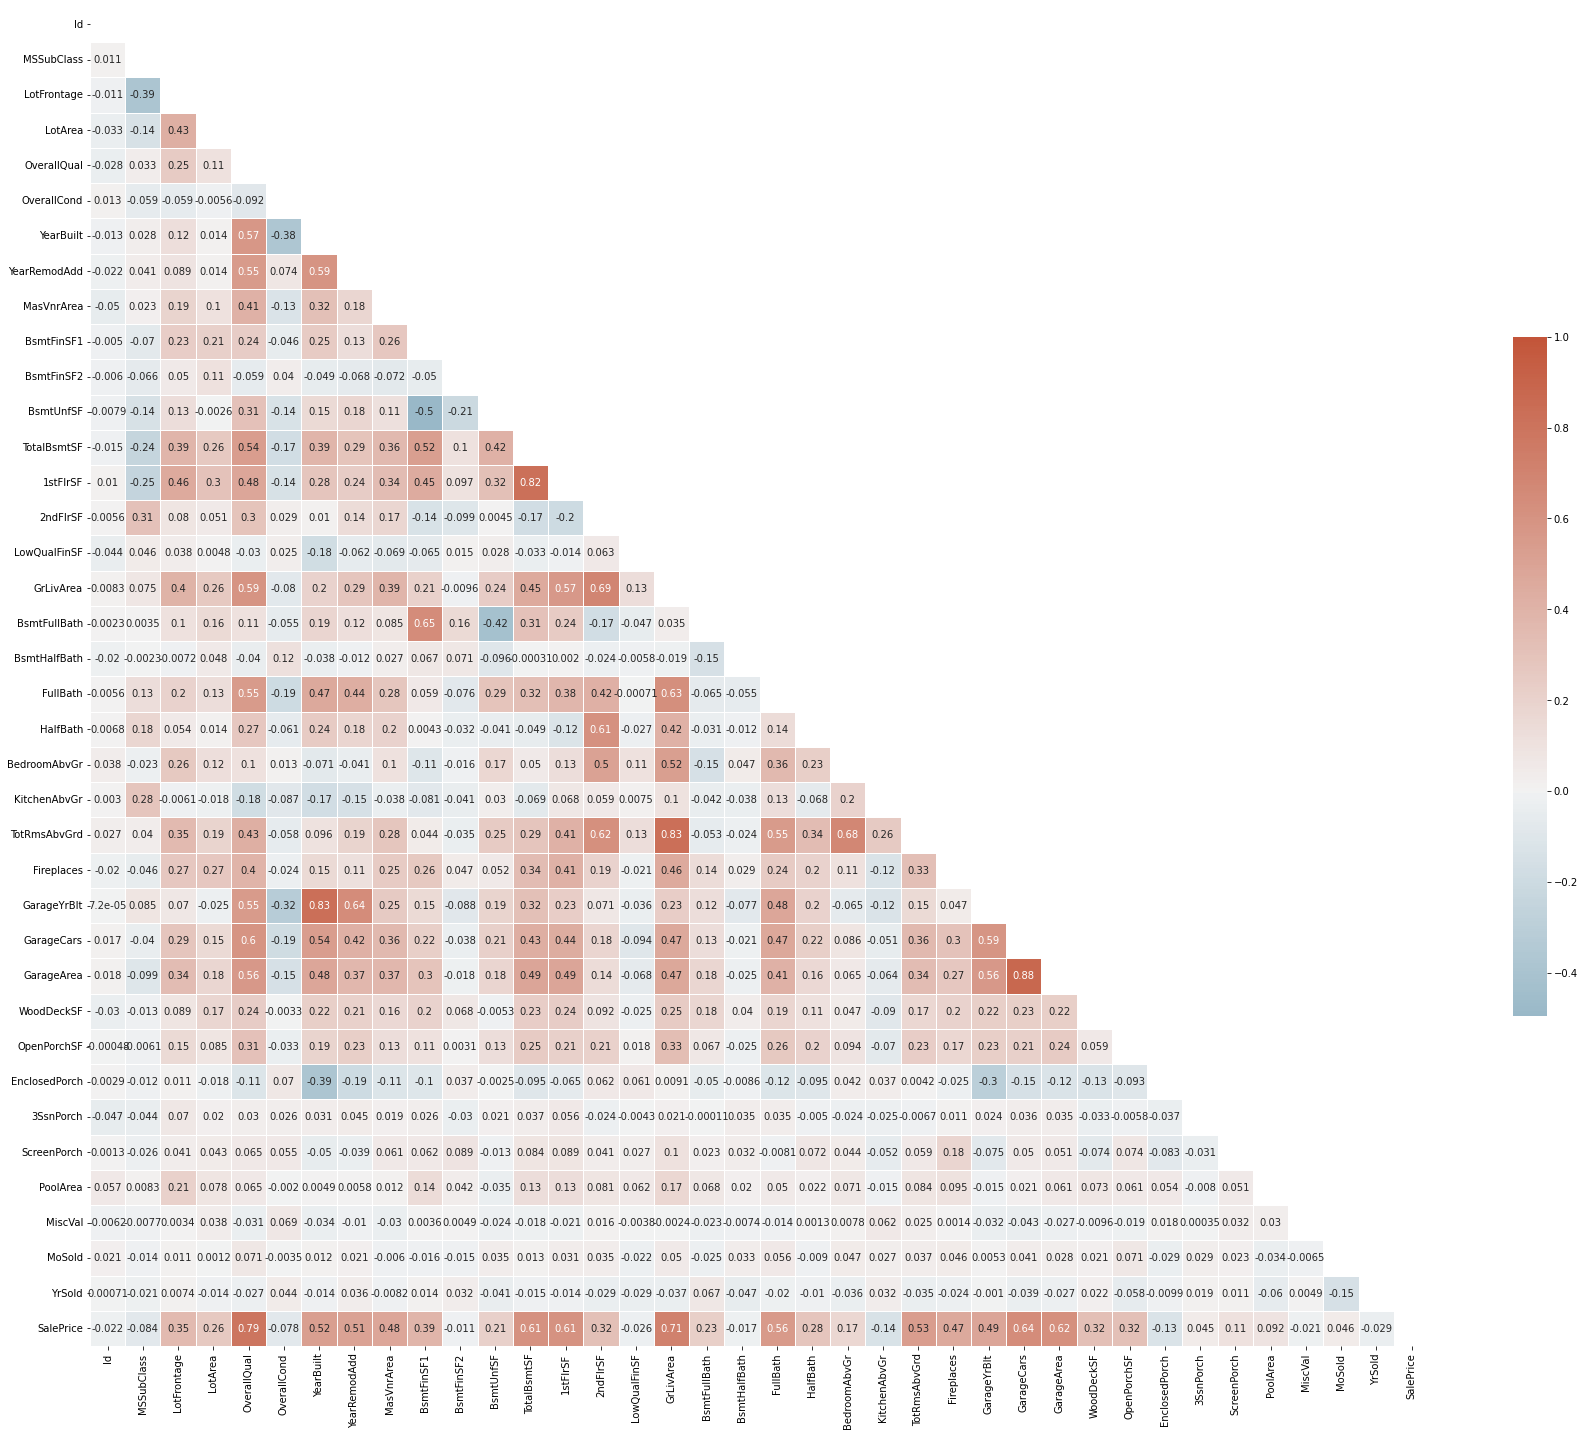

In [4]:
# Correlation Matrix

f, ax = plt.subplots(figsize=(30, 25))
mat = df.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sbn.diverging_palette(230, 20, as_cmap=True)
sbn.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [5]:
thresH=20

nan = pd.DataFrame(df.isna().sum(), columns = ['NaN_sum'])
nan['feat'] = nan.index
nan['Perc(%)'] = (nan['NaN_sum']/1460)*100
nan = nan[nan['NaN_sum'] > 0]
nan = nan.sort_values(by = ['NaN_sum'])
nan['Usability'] = np.where(nan['Perc(%)'] > thresH, 'Discard', 'Keep')
nan

,NaN_sum,feat,Perc(%),Usability
Electrical,1,Electrical,0.068493,Keep
MasVnrType,8,MasVnrType,0.547945,Keep
MasVnrArea,8,MasVnrArea,0.547945,Keep
BsmtQual,37,BsmtQual,2.534247,Keep
BsmtCond,37,BsmtCond,2.534247,Keep
BsmtFinType1,37,BsmtFinType1,2.534247,Keep
BsmtExposure,38,BsmtExposure,2.602740,Keep
BsmtFinType2,38,BsmtFinType2,2.602740,Keep
GarageCond,81,GarageCond,5.547945,Keep
GarageQual,81,GarageQual,5.547945,Keep


In [6]:
for dff in [df,df_test]: 
    dff['MSSubClass'] = dff['MSSubClass'].apply(str)
    dff['YrSold'] = dff['YrSold'].apply(str)
    dff['MoSold'] = dff['MoSold'].apply(str)

    dff['Functional'] = dff['Functional'].fillna('Typ')
    dff['Electrical'] = dff['Electrical'].fillna("SBrkr")
    dff['KitchenQual'] = dff['KitchenQual'].fillna("TA")
    dff['Exterior1st'] = dff['Exterior1st'].fillna(dff['Exterior1st'].mode()[0])
    dff['Exterior2nd'] = dff['Exterior2nd'].fillna(dff['Exterior2nd'].mode()[0])
    dff['SaleType'] = dff['SaleType'].fillna(dff['SaleType'].mode()[0])

    for col in ['MiscFeature','Fence','FireplaceQu',"Alley","PoolQC",'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        dff[col] = dff[col].fillna("None")
    

In [7]:
pd.set_option('display.max_rows',None)
df.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath 

In [8]:
df.drop(['GarageYrBlt','YearRemodAdd'] , axis = 1,inplace=True)
df_test.drop(['GarageYrBlt','YearRemodAdd'] , axis = 1,inplace=True)

In [9]:
df.isnull().sum()


Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
Alley              0
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
RoofStyle          0
RoofMatl           0
Exterior1st        0
Exterior2nd        0
MasVnrType         8
MasVnrArea         8
ExterQual          0
ExterCond          0
Foundation         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinSF1         0
BsmtFinType2       0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Heating            0
HeatingQC          0
CentralAir         0
Electrical         0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [14]:
for x in [df,df_test]:
    for i in x.columns:
        if x[i].isna().sum()!=0 and x[i].dtype!='object':
            x[i].fillna(x[i].mean(),inplace=True) #Eksik verilere ortalama alınarak yaklaşılıyor
    x['MSSubClass'] = x['MSSubClass'].apply(str)
    x['YrSold'] = x['YrSold'].apply(str)
    x['MoSold'] = x['MoSold'].apply(str)

df=pd.get_dummies(df)
df_test=pd.get_dummies(df_test)

In [15]:
for dff in [df,df_test]:
    numeric_features = dff.dtypes[dff.dtypes != object].index
    skewed_features = dff[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_features[skewed_features > 0.5]
    skew_index = high_skew.index


    for i in skew_index:
        dff[i] = np.log1p(dff[i])

In [16]:
df.drop('Id',axis=1,inplace=True)
df_test.drop('Id',axis=1,inplace=True)

In [17]:
pd.set_option('display.max_rows',None)
df.isnull().sum()

LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
YearBuilt                0
MasVnrArea               0
BsmtFinSF1               0
BsmtFinSF2               0
BsmtUnfSF                0
TotalBsmtSF              0
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             0
BsmtHalfBath             0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
TotRmsAbvGrd             0
Fireplaces               0
GarageCars               0
GarageArea               0
WoodDeckSF               0
OpenPorchSF              0
EnclosedPorch            0
3SsnPorch                0
ScreenPorch              0
PoolArea                 0
MiscVal                  0
SalePrice                0
MSSubClass_120           0
MSSubClass_160           0
MSSubClass_180           0
MSSubClass_190           0
MSSubClass_20            0
M

In [19]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

In [20]:
X_train=df.drop('SalePrice',axis=1)
y_train=df['SalePrice']

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(df_test)

ValueError: X has 312 features, but StandardScaler is expecting 329 features as input.

In [25]:
df_test.shape

(1459, 312)

In [68]:
clf=RandomForestRegressor(random_state=2,max_depth= 8,n_estimators= 120)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
y_pred.shape

(1442,)

In [67]:
submission = pd.read_csv("sample_submission.csv")
submission["SalePrice"] = y_pred
submission.to_csv('submission.csv', index=False)

ValueError: Length of values (1442) does not match length of index (1459)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m ""